In [1]:
# Automated Sim for Optimal Points Testing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

In [3]:
# Functions

def generate_students(rng, num_applicants, b_rate):

    b_num = round(num_applicants * b_rate)
    w_num = round(num_applicants - b_num)
    
    # 100 and 15 are the mean and SD for IQs in the general population
    w_dist = 15 * rng.standard_normal(w_num) + 100
    b_dist = 15 * rng.standard_normal(b_num) + 100

    return w_dist, b_dist

def generate_bias(rng, num_applicants, b_rate, avg, sd):

    b_num = round(num_applicants * b_rate)
    
    bias = sd * rng.standard_normal(b_num) + avg

    return bias

def select_students_bonus(b_dist, w_dist, quota, bias, bonus):

    if quota == 0:
        quota = round((w_dist.size + b_dist.size) / 10) 
    
    # Race must be a number otherwise there's some dtype conflict with argsort()
    w_race = np.full((w_dist.size), 0)
    b_race = np.full((b_dist.size), 1)
    
    # Pair each applicant's true IQ with their apparent IQ due to discrimination, also mark race
    b_dist_2d = np.stack((b_dist, b_dist - bias + bonus, b_race), axis=-1)
    w_dist_2d = np.stack((w_dist, w_dist, w_race), axis=-1)

    both_dist_2d = np.concatenate([b_dist_2d, w_dist_2d])
    both_dist_2d = both_dist_2d[both_dist_2d[:, 1].argsort()] # sort by biased IQ
    both_dist_2d_true = both_dist_2d[both_dist_2d[:, 0].argsort()] # sort by true IQ

    both_accepted_2d = both_dist_2d[-quota:] # select top students
    both_accepted_2d_true = both_dist_2d_true[-quota:]

    #w_accepted_2d = both_accepted_2d[(np.transpose(both_accepted_2d)[2] == 0)]
    #b_accepted_2d = both_accepted_2d[(np.transpose(both_accepted_2d)[2] == 1)]

    total_IQ_loss = (
        np.average(np.transpose(both_accepted_2d_true)[0]) - 
        np.average(np.transpose(both_accepted_2d)[0])
    ) * quota
    
    return total_IQ_loss#, b_accepted_2d, w_accepted_2d

def find_optimal_bonus(w_dist, b_dist, quota, bias, upper_bound, lower_bound, increment, digits):

    optimal_bonus = lower_bound
    lowest_IQ_loss = float('inf')

    for digit in range(digits):

        bonus_points_arr = np.arange(lower_bound, upper_bound, increment)
    
        for bonus in bonus_points_arr:
        
            IQ_loss = select_students_bonus(b_dist, w_dist, quota, bias, bonus)#[0]

            if IQ_loss < lowest_IQ_loss:
                lowest_IQ_loss = IQ_loss
                optimal_bonus = bonus

        lower_bound = optimal_bonus - increment
        upper_bound = optimal_bonus + increment
        increment = increment / 10

    return(optimal_bonus, lowest_IQ_loss)

def vary_sim_across(vars_dict):

    # Produces all possible combination of variables
    vars_list = list(itertools.product(*vars_dict.values()))

    # For ease of reading only, values not used
    rng = 0
    num_applicants = 1
    b_rate = 2
    quota = 3
    bias_avg = 4
    bias_sd = 5
    lower_bound = 6
    upper_bound = 7
    increment = 8
    digits = 9
    num_rounds = 10

    all_optimal_bonuses = []
    all_IQ_losses = []

    for vars in vars_list:
        
        optimal_bonuses = np.zeros(shape=vars[num_rounds])
        IQ_losses = np.zeros(shape=vars[num_rounds])
        
        for r in range(vars[num_rounds]):
                
            w_dist, b_dist = generate_students(
                vars[rng],
                vars[num_applicants],
                vars[b_rate])
                
            bias = generate_bias(
                vars[rng],
                vars[num_applicants], 
                vars[b_rate],
                vars[bias_avg],
                vars[bias_sd])
                
            this_optimal_bonus, this_IQ_loss = find_optimal_bonus(
                w_dist,
                b_dist,
                vars[quota],
                bias,
                vars[upper_bound],
                vars[lower_bound],
                vars[increment],
                vars[digits])
                    
            optimal_bonuses[r] = this_optimal_bonus
            IQ_losses[r] = this_IQ_loss

        this_average_optimal_bonus = round(np.average(optimal_bonuses),3)
        this_average_IQ_loss = round(np.average(IQ_losses),3)

        all_optimal_bonuses.append(this_average_optimal_bonus)
        all_IQ_losses.append(this_average_IQ_loss)

    # Add averages of optimal bonuses and IQ losses to the input variables, return all as result
    results = np.column_stack((vars_list, all_optimal_bonuses, all_IQ_losses))
    
    return results


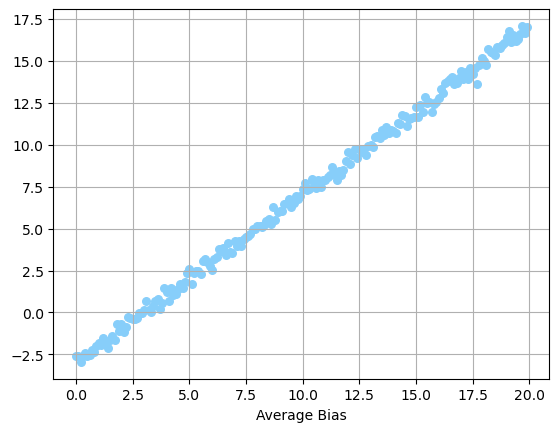

In [16]:
# Vary Bias Average

vars = {                                       # These values affect the simulation qualitatively:
    
    'rng':[np.random.default_rng(8222024112)], # Standard seed for repeatability 
    'num_applicants':[10_000],                 # Number of people who apply to the college
    'b_rate':[0.5],                            # Rate of minority students (0.5 = 50%)
    'quota':[1000],                            # How selective the college is (1000 is 10%)
    'bias_avg':np.arange(0,20,0.1),            # Average level of bias against minority students (0 thru 20 in increments of 0.1)
    'bias_sd':[6],                             # SD of bias against minority students

                                               # These values optimize the speed of the simulation:
    
    'lower_bound':[-30],                       # Lower bound of tested bonuses
    'upper_bound':[30],                        # Upper bound of tested bonuses
    'increment':[1],                           # For optimization
    'digits':[2],                              # Number of significant decimals in tested bonuses
    'num_rounds':[10]                          # Number of times to run simulations with the above variables, averaged together
}

results = vary_sim_across(vars)

average = results.transpose()[4]
optimal_values = results.transpose()[11]

colors = 'lightskyblue'
area = 30

#plt.figure(dpi=1000)
plt.grid()
plt.scatter(average, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Average Bias')
plt.show()

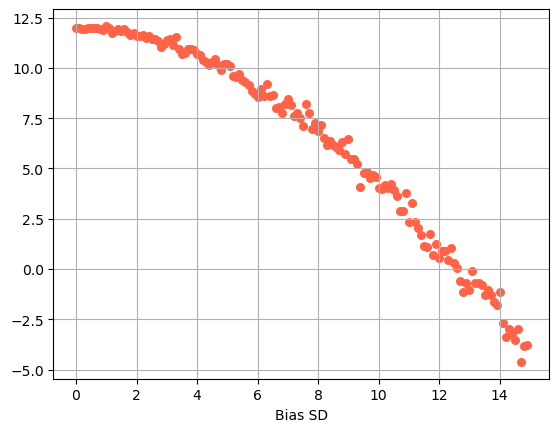

In [7]:
# Vary Bias SD

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':[1000],
    'bias_avg':[12],
    'bias_sd':np.arange(0,15,0.1),

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

sd = results.transpose()[5]
optimal_values = results.transpose()[11]

colors = 'tomato'
area = 30

plt.scatter(sd, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Bias SD')
plt.grid()
plt.show()

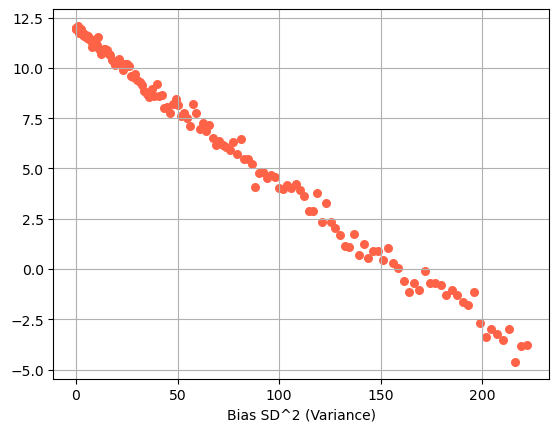

In [11]:
variance = np.square(sd)

plt.scatter(variance, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Bias SD^2 (Variance)')
plt.grid()
plt.show()

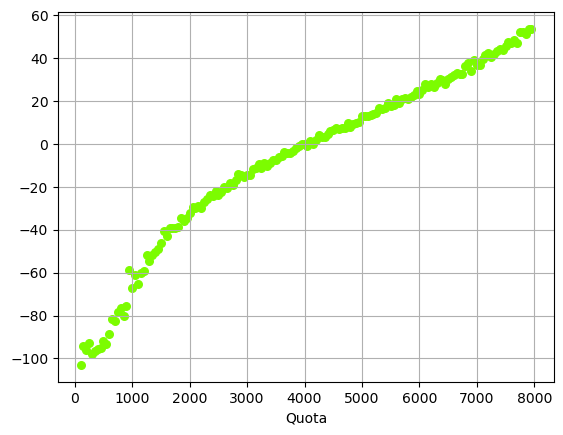

In [86]:
# Vary Quota

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':np.arange(100,8000,50),
    'bias_avg':[12],
    'bias_sd':[36], # change back to 6 later

    'lower_bound':[-100], # change back to 30 later
    'upper_bound':[60],
    'increment':[10],
    'digits':[3],
    'num_rounds':[10] # try again with 100
}

results = vary_sim_across(vars)

quota = results.transpose()[3]
optimal_values = results.transpose()[11]

colors = 'lawngreen'
area = 30

plt.grid()
plt.scatter(quota, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Quota')
plt.show()

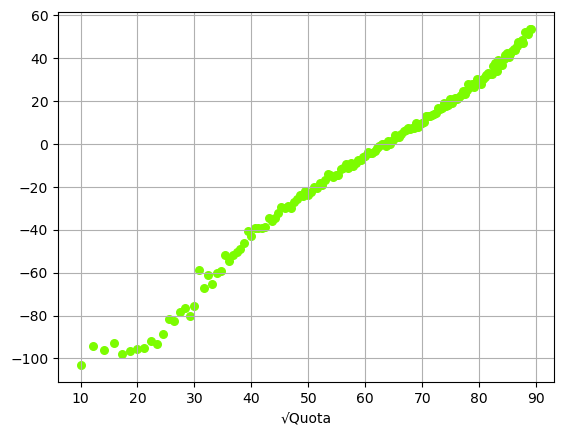

In [87]:
sqrt_quota = [n**0.5 for n in quota]

plt.grid()
plt.xlabel('√Quota')
plt.scatter(sqrt_quota, optimal_values, s=area, c=colors, alpha=1)
plt.show()

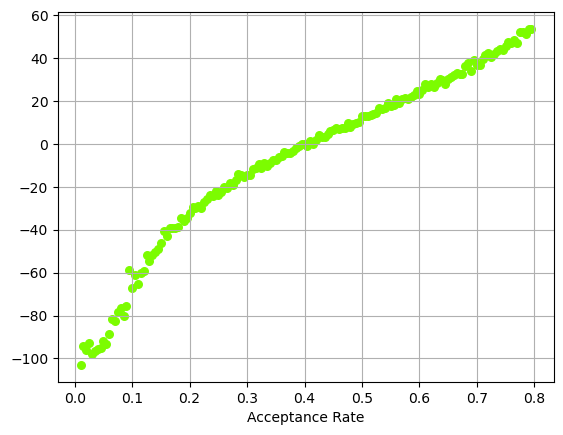

In [119]:
acceptance_rate = quota / 10_000

plt.grid()
plt.xlabel('Acceptance Rate')
plt.scatter(acceptance_rate, optimal_values, s=area, c=colors, alpha=1)
plt.show()

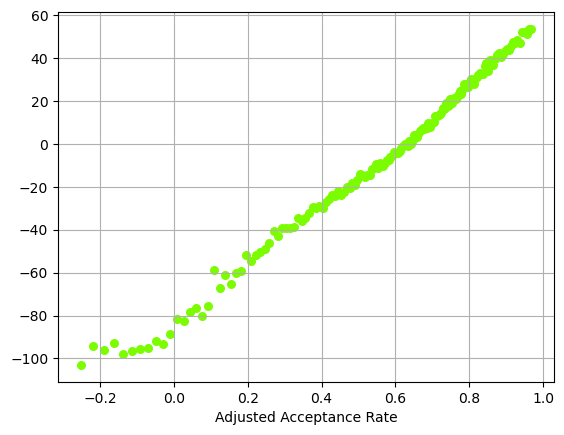

In [136]:
adj_ar = [(n**0.5) + 3*(n - 0.5)**3 for n in acceptance_rate]

plt.grid()
plt.xlabel('Adjusted Acceptance Rate')
plt.scatter(adj_ar, optimal_values, s=area, c=colors, alpha=1)
plt.show()

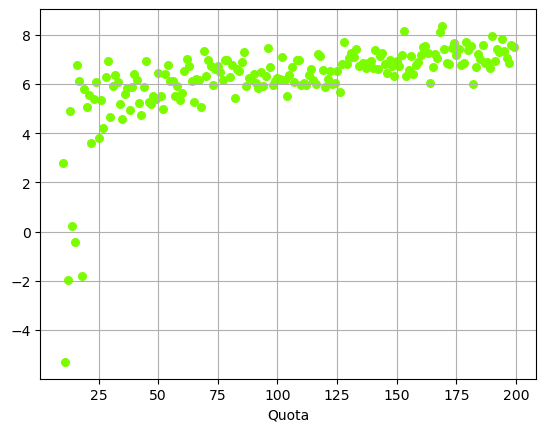

In [29]:
# Vary Quota, Focus on Small Values

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':np.arange(10,200,1),
    'bias_avg':[12],
    'bias_sd':[6],

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

quota = results.transpose()[3]
optimal_values = results.transpose()[11]

colors = 'lawngreen'
area = 30

plt.grid()
plt.xlabel('Quota')
plt.scatter(quota, optimal_values, s=area, c=colors, alpha=1)
plt.show()

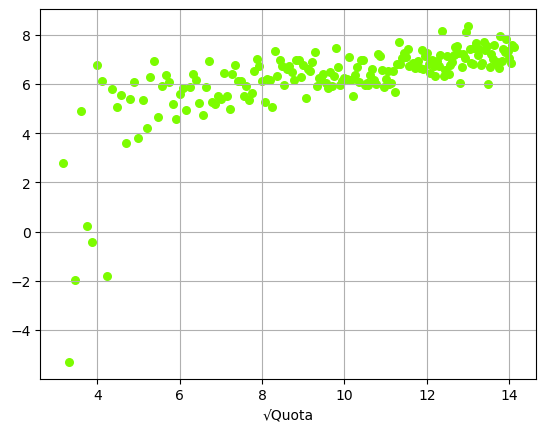

In [30]:
sqrt_quota = [n**0.5 for n in quota]

plt.grid()
plt.xlabel('√Quota')
plt.scatter(sqrt_quota, optimal_values, s=area, c=colors, alpha=1)
plt.show()

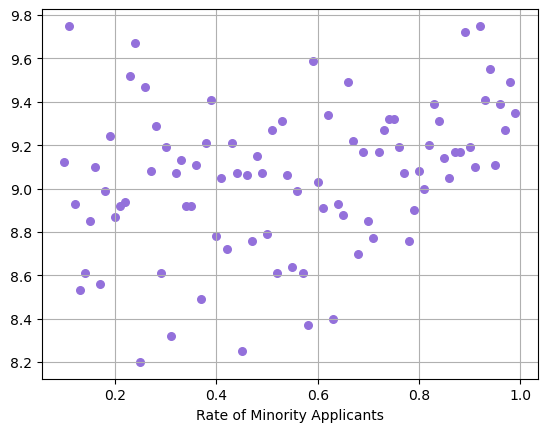

In [24]:
# Vary B Rate

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':np.arange(0.1,1,0.01),
    'quota':[1000],
    'bias_avg':[12],
    'bias_sd':[6],

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

b_rate = results.transpose()[2]
optimal_values = results.transpose()[11]

colors = 'mediumpurple'
area = 30

plt.grid()
plt.scatter(b_rate, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Rate of Minority Applicants')
plt.show()

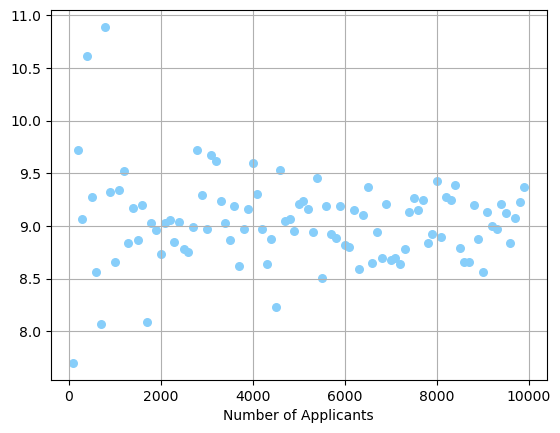

In [22]:
# Vary Number of Applicants, Acceptance Rate Constant at 10%

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':np.arange(100, 10_000, 100),
    'b_rate':[0.5],
    'quota':[0],
    'bias_avg':[12],
    'bias_sd':[6],

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

applicants = results.transpose()[1]
optimal_values = results.transpose()[11]

colors = 'lightskyblue'
area = 30

plt.grid()
plt.scatter(applicants, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Number of Applicants')
plt.show()

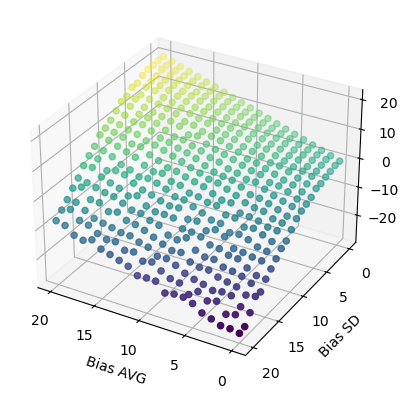

In [31]:
# Vary SD and Average of Bias

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':[1000],
    'bias_avg':np.arange(0,21,1),
    'bias_sd':np.arange(0,21,1),

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

bias_avg = results.transpose()[4]
bias_sd = results.transpose()[5]
optimal_values = results.transpose()[11]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(bias_avg, bias_sd, optimal_values, c=optimal_values, cmap='viridis')

ax.set_xlabel('Bias AVG')
ax.set_ylabel('Bias SD')

ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

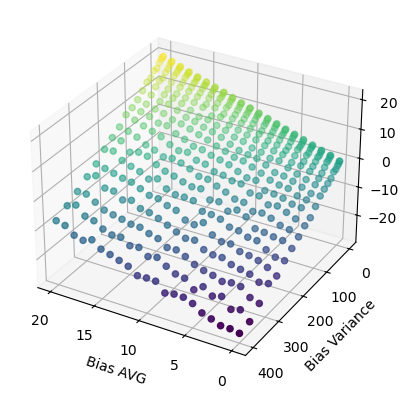

In [42]:
variance = [n**2 for n in bias_sd]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(bias_avg, variance, optimal_values, c=optimal_values, cmap='viridis')

ax.set_xlabel('Bias AVG')
ax.set_ylabel('Bias Variance')

ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

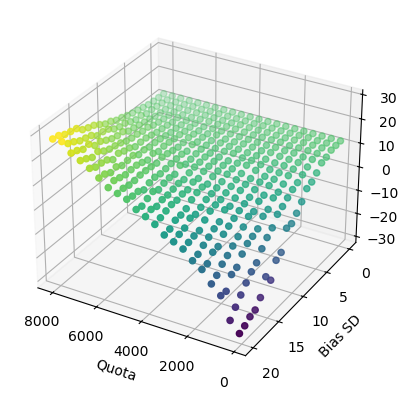

In [17]:
# Vary SD and Quota

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':np.arange(100,8500,400),
    'bias_avg':[12],
    'bias_sd':np.arange(0,21,1),

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10] # change back to 10
}

results = vary_sim_across(vars)

quota = results.transpose()[3]
bias_sd = results.transpose()[5]
optimal_values = results.transpose()[11]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(quota, bias_sd, optimal_values, c=optimal_values, cmap='viridis')

ax.set_xlabel('Quota')
ax.set_ylabel('Bias SD')

ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

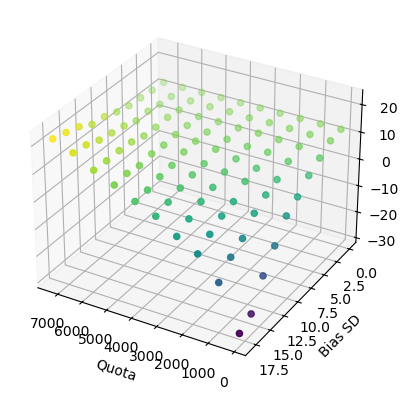

In [23]:
# TODO: Try to figure out what this interaction is

# Vary SD and Quota

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':np.arange(100,8100,800),
    'bias_avg':[12],
    'bias_sd':np.arange(0,20,2),

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10] # change back to 10
}

results = vary_sim_across(vars)

quota = results.transpose()[3]
bias_sd = results.transpose()[5]
optimal_values = results.transpose()[11]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(quota, bias_sd, optimal_values, c=optimal_values, cmap='viridis')

ax.set_xlabel('Quota')
ax.set_ylabel('Bias SD')

ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

In [8]:
# For testing, can delete later
#quotas = results.transpose()[3]
#acceptance_rates = quotas / 10_000
#standard_devs = results.transpose()[5]
#optimal_values = results.transpose()[11]
#for i in range(len(results)):
#    print(f"{standard_devs[i]},{optimal_values[i]},{acceptance_rates[i]}")

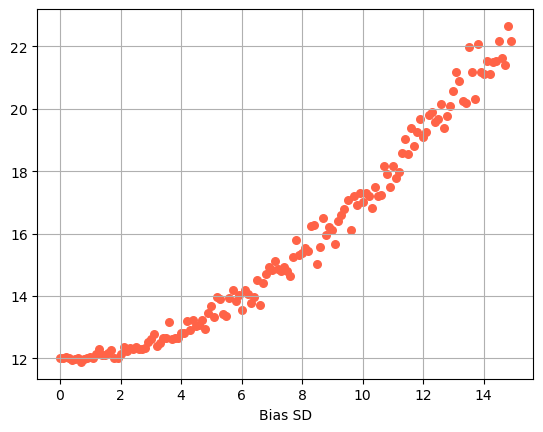

In [18]:
# Vary Bias SD, 80% Acceptance Rate

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':[8000],
    'bias_avg':[12],
    'bias_sd':np.arange(0,15,0.1),

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

sd = results.transpose()[5]
optimal_values = results.transpose()[11]

colors = 'tomato'
area = 30

plt.scatter(sd, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Bias SD')
plt.grid()
plt.show()

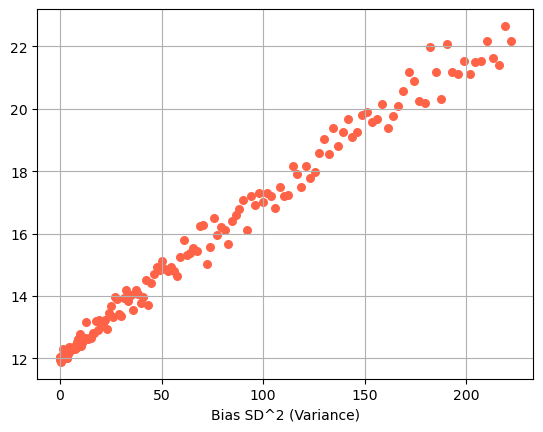

In [19]:
variance = np.square(sd)

plt.scatter(variance, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Bias SD^2 (Variance)')
plt.grid()
plt.show()

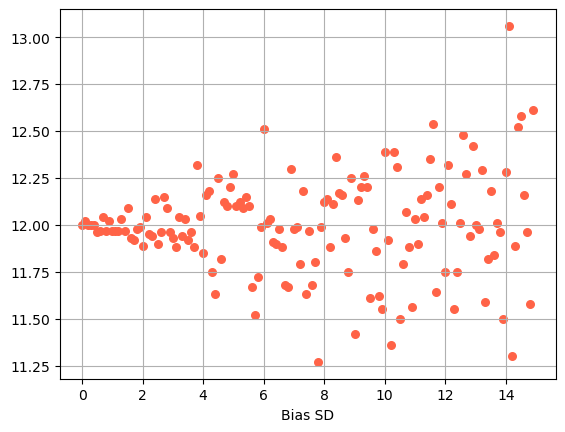

In [20]:
# Vary Bias SD, 50% Acceptance Rate

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':[5000],
    'bias_avg':[12],
    'bias_sd':np.arange(0,15,0.1),

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

sd = results.transpose()[5]
optimal_values = results.transpose()[11]

colors = 'tomato'
area = 30

plt.scatter(sd, optimal_values, s=area, c=colors, alpha=1)
plt.xlabel('Bias SD')
plt.grid()
plt.show()

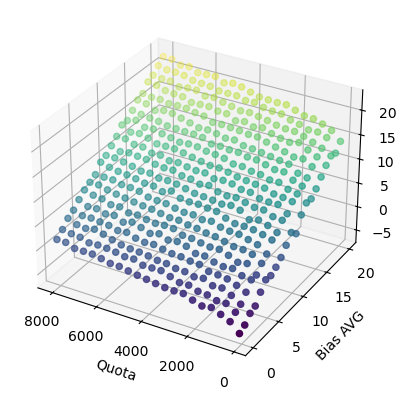

In [52]:
# Vary Average of Bias and Quota

vars = {
    'rng':[np.random.default_rng(8222024112)],
    'num_applicants':[10_000],
    'b_rate':[0.5],
    'quota':np.arange(100,8500,400),
    'bias_avg':np.arange(0,21,1),
    'bias_sd':[6],

    'lower_bound':[-30],
    'upper_bound':[30],
    'increment':[1],
    'digits':[2],
    'num_rounds':[10]
}

results = vary_sim_across(vars)

quota = results.transpose()[3]
bias_avg = results.transpose()[4]
optimal_values = results.transpose()[11]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(quota, bias_avg, optimal_values, c=optimal_values, cmap='viridis')

ax.set_xlabel('Quota')
ax.set_ylabel('Bias AVG')

ax.invert_xaxis()

plt.show()

In [ ]:
"""
From the tests I'm gathering the following:
    Bias Average has a positive linear correlation with Optimal Compensation
    Bias SD has a squared correlation with Optimal Compensation
        Bias Variance has a linear correlation with Optimal Compensation
    Quota/Acceptance Rate have a positive square root correlation wth Optimal Compensation
        May also have a cubed correlation with OC, need to look into that further
    Bias AVG and Quota have no interaction
    Bias AVG and Bias SD have no interaction
    Quota/Acceptance Rate and Bias SD have an interaction
        When Acceptance Rate > ~0.5, Bias SD has a positive correlation with Optimal Compensation
        When Acceptance Rate < ~0.5, Bias SD has a negative correlation with Optimal Compensation
        When Acceptance Rate is far from ~0.5, Bias SD has a stronger correlation with Optimal Compensation
        When Bias SD is 0/close to 0, Acceptance Rate has no/little correlation with OC
        0.5 is not the B Rate since this interaction remains the same when B Rate is varied
"""